In [1]:
# Import requirements
from lsst.daf.persistence import Butler
import matplotlib as mpl
import matplotlib.pyplot as plt
import modelling_research.dc2 as dc2
import modelling_research.match_refcat as mrMatch
import modelling_research.meas_model as mrMeas
import modelling_research.plot_matches as mrPlotMatches
import numpy as np
import seaborn as sns

In [2]:
# Turn off loading/testing MultiProFit catalogs here
plot_multiprofit = False

In [3]:
# Plot settings
mpl.rcParams['figure.dpi'] = 160
mpl.rcParams['image.origin'] = 'bottom'
mpl.rcParams['figure.figsize'] = 10, 20
sns.set(rc={'axes.facecolor': '0.85', 'figure.facecolor': 'w'})
sns.set_style('darkgrid')

In [4]:
# Bands and colour balance
bands_weights = {'i': 1.0, 'r': 1.191, 'g': 2.249}

# Reference band for when we need to pick one
band_ref = 'r'
band_fit = 'griz'

# Common plot arguments
mag_max = 24.5
match_dist_asec = 0.168
kwargs_plot = dict(scatterleft=True, scatterright=True, limx=(14.5, mag_max), limy= (-0.6, 1.4))

In [5]:
# Load the truth catalogs and count all of the rows
butler_ref = dc2.get_refcat(make=False)

# Load the Scarlet repo
truth_path = dc2.get_truth_path()
butlers_dc2_scarlet = {
    '2.2i': Butler(f'{truth_path}/scarlet/2020-12-17/ugrizy'),
}

In [6]:
# Specify patches and bands
tract = 3828
patch_regex = "[3],[3]"
bands_single = tuple([x for x in 'griz'])
band_ref = 'r'
band_multi = 'griz'

In [7]:
# Set up models to plot
model_specs = [
    ('Stack CModel', 'modelfit_CModel', 2),
    ('Forced CModel', 'modelfit_forced_CModel', 2),
    ('Scarlet', 'scarlet', 0),
]
models = {
    desc: mrMeas.Model(desc, field, n_comps)
    for desc, field, n_comps in model_specs
}

In [8]:
# Load the MultiProFit catalogs
if plot_multiprofit:
    path_scarlet = f'{truth_path}/scarlet/2020-12-17_mpf-noiseReplacer/'
    bands_multi = (band_multi,)
    tracts = {tract: (path_scarlet, '2.2i'), }

    # Match with the refcat using afw's DirectMatchTask to select refcat entries and astropy to actually match
    cats = dc2.match_refcat_dc2(
        butler_ref, match_afw=False, tracts=tracts, butlers_dc2=butlers_dc2_scarlet, filters_single=bands_single,
        filters_multi=bands_multi, patches_regex=patch_regex,
    )

In [9]:
# Make galaxy plots
if plot_multiprofit:
    select_truths = mrPlotMatches.plot_matches(
        cats, True, models, (band_ref,), band_ref=band_ref, band_multi=band_multi,
        band_ref_multi=band_ref, mag_max=mag_max, match_dist_asec=match_dist_asec,
        plot_compure=False, rematch=True, return_select_truth=True, **kwargs_plot,
    )

In [10]:
# Now do the same with the original Scarlet catalogs
path_scarlet = f'{truth_path}/scarlet/2020-12-17/ugrizy/'
get_path_cats = mrMatch.get_path_cats_butlerg2
func_patch = mrMatch.func_patch_butlerg2
bands_multi = tuple()

tracts = {tract: (path_scarlet, '2.2i'), }

# Match with the refcat using afw's DirectMatchTask to select refcat entries and astropy to actually match
# ... in this case, specifying different functions to glob and parse catalog paths
# Of course we should be using butler functions but it's slightly harder to search for catalogs with
# existing methods, although it is possible given that we know the min/max patch ids and don't have to
# use a wildcard. Oh well.
cats = dc2.match_refcat_dc2(
    butler_ref, match_afw=False, tracts=tracts, butlers_dc2=butlers_dc2_scarlet, filters_single=bands_single,
    filters_multi=bands_multi, patches_regex=patch_regex, func_path=get_path_cats, func_patch=func_patch,
)

Loading tract 3828 band r
Loading 1 files from path=/project/dtaranu/dc2//scarlet/2020-12-17/ugrizy//deepCoadd-results/r/3828/[3],[3]/meas-r-3828-[3],[3].fits
Loaded in 24.1s; loading 3,3 (1/1) and matching file=/project/dtaranu/dc2//scarlet/2020-12-17/ugrizy//deepCoadd-results/r/3828/3,3/meas-r-3828-3,3.fits; len(cat,truth)=17122,103108
Loading tract 3828 band g
Loading 1 files from path=/project/dtaranu/dc2//scarlet/2020-12-17/ugrizy//deepCoadd-results/g/3828/[3],[3]/meas-g-3828-[3],[3].fits
Loaded in 2.3s; loading 3,3 (1/1) file=/project/dtaranu/dc2//scarlet/2020-12-17/ugrizy//deepCoadd-results/g/3828/3,3/meas-g-3828-3,3.fits; len(cat,truth)=17122,103108
Loading tract 3828 band i
Loading 1 files from path=/project/dtaranu/dc2//scarlet/2020-12-17/ugrizy//deepCoadd-results/i/3828/[3],[3]/meas-i-3828-[3],[3].fits
Loaded in 1.9s; loading 3,3 (1/1) file=/project/dtaranu/dc2//scarlet/2020-12-17/ugrizy//deepCoadd-results/i/3828/3,3/meas-i-3828-3,3.fits; len(cat,truth)=17122,103108
Loading 

In [11]:
# Make plots of the matches and get their indices
# (all of this mess is a refactored subset of what's in plot_matches)
# Could make these same plots with MultiProFit catalogs, skipping plot_matches
use_multiprofit_cats = False
cats_type = cats[tract]
band_cat = band_multi if use_multiprofit_cats else band_ref
cat_truth, cat_meas = cats_type['truth'], cats_type['meas'][band_cat]
# This selects resolved objects, and should be identical to select_truths[3828]
# I did this because I had a very bad time with flag columns in afw tables. I think that was fixed recently
select_truth = (cat_truth['id'] > 0) == True
mags_true = {band: -2.5 * np.log10(cat_truth[f'lsst_{band}_flux']) + 31.4 for band in bands_single}

indices, dists = (cats_type[x] for x in ('indices1', 'dists1'))
# Cheat a little and set negatives to -1
indices[dists > match_dist_asec] = -1
# bincount only works on non-negative integers, but we want to preserve the true indices and
# don't need the total count of unmatched sources
n_matches = np.bincount(indices + 1)[1:]
matches_multi = n_matches > 1
mags_true_ref = mags_true[band_ref]

# set multiple matches to integers < -1
for idx in np.where(matches_multi)[0]:
    matches = np.where(indices == idx)[0]
    brightest = np.argmax(mags_true_ref[matches])
    indices[matches] = -idx - 2
    indices[matches[brightest]] = idx

indices_galaxy = indices[select_truth]
good = indices_galaxy >= 0
cat_meas_good = cat_meas.copy(deep=True).asAstropy()[indices_galaxy[good]]

1 child parents: {8418073623135232, 8418073623142294, 8418073623137821, 8418073623136165, 8418073623140140, 8418073623136685, 8418073623138862, 8418073623140146, 8418073623139385, 8418073623134524, 8418073623140032, 8418073623138380, 8418073623134541, 8418073623141600, 8418073623142370, 8418073623134709, 8418073623140085, 8418073623139193, 8418073623135099, 8418073623135359}


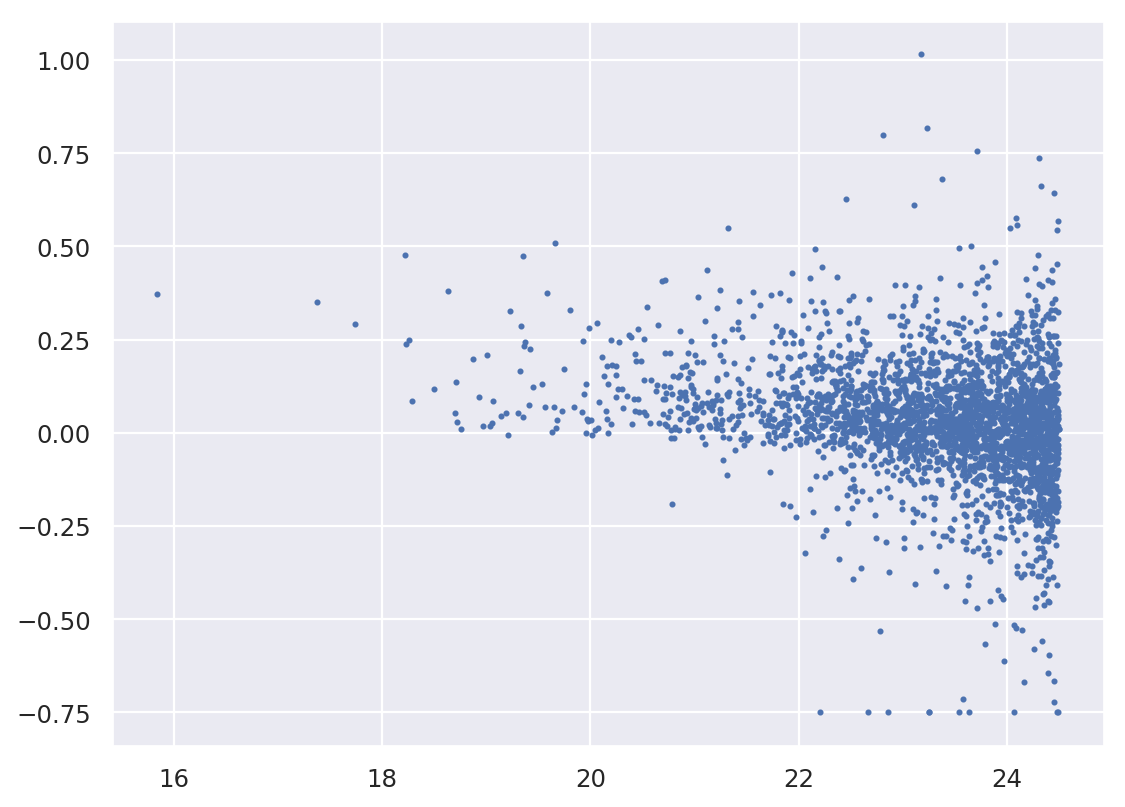

In [12]:
# Plot and print good matches
mag_meas = models['Scarlet'].get_mag_total(cat_meas_good, band_ref) if use_multiprofit_cats else (
    -2.5*np.log10(cat_meas_good['deblend_scarletFlux']) + 27)
mag_true = mags_true_ref[select_truth][good]
mag_delta = np.clip(mag_meas - mag_true, -0.75, 1.25)
bright = mag_true < 24.5

plt.figure(figsize=(8, 6))
plt.scatter(mag_true[bright], mag_delta[bright], s=3)

bad = ((mag_meas < 24) & (mag_meas > 23) & (mag_delta > 0.3))
ids_parent, counts = np.unique(cat_meas_good['parent'][bad], return_counts=True)
parents_counts = {count: set() for count in np.unique(counts)}
for id_parent, count in zip(ids_parent, counts):
    parents_counts[count].add(id_parent)
for count, parents in parents_counts.items():
    print(f'{count} child parents:', parents)